In [53]:
from collections import defaultdict
import pickle

import numpy as np
import pandas as pd

from text_tools import restore_punctuation, spell_text, combine_speech_and_speakers

### Checking diarization

бизнес вслепую - совсем тяжко отработал алгоритм

In [54]:
with open('data/diarization_dct.pkl', mode='rb') as f:
    diarization_dct = pickle.load(f)

In [55]:
# Количество обнаруженных спикеров (в идеале должно быть 6)
n_speakers_dct = {}
for key, value in diarization_dct.items():
    n_speakers = len(set([subdct['speaker'] for subdct in value if subdct['start']]))
    n_speakers_dct[key] = n_speakers
    
n_speakers_dct

{'20200513 - Верните деньги': 2,
 '20200422 - Бизнес «вслепую»': 1,
 '20200520 - Собеседование': 2,
 '20200415 - Старикам у нас почет': 2,
 '20200712 - Потерянный миллион': 3,
 '20200415 - Спор Директоров 1': 2,
 '20200408 - Бойкот 2': 3,
 '20200408 - Бойкот': 2,
 '20200506 - Поторопились': 2,
 '20200415 - Спор директоров 2': 2,
 '20200513 - Осмелились ослушаться': 1,
 '20200408 - Рокировка по этажам': 3,
 '20200408 - Ценный сотрудник': 3,
 '20200422 - Нежданный заместитель': 3,
 '20200429 - Конкуренция сотрудников': 2,
 '20200415 - Юридическая ошибка': 3,
 '20200408 - Аттестация для всех': 1,
 '20200603 - Свой-чужой': 1,
 '20200415 - Премия': 2,
 '20200520 - Гонорар 2': 3,
 '20200429 - Конфликтный сотрудник': 2,
 '20200422 - Играть нельзя работать': 2,
 '20200520 - Гонорар 1': 2,
 '20200415 - Cherchez la femme': 2,
 '20200520 - Уникальный станочник': 1,
 '20200429 - Нежелательный переезд': 2,
 '20200520 - Задержка ответа': 2,
 '20200429 - Мистические условия': 2,
 '20200520 - Стук ко

In [56]:
time_speakers_dct = {}
for key, value in diarization_dct.items():
    temp_dct = defaultdict(lambda: 0)
    for line in value:
        temp_dct[line['speaker']] += line['stop'] - line['start']
    print(key, temp_dct)
    print()

20200513 - Верните деньги defaultdict(<function <lambda> at 0x7fe479923f70>, {'SPEAKER_00': 239.405625, 'SPEAKER_01': 225.21375000000006})

20200422 - Бизнес «вслепую» defaultdict(<function <lambda> at 0x7fe4799171f0>, {'SPEAKER_00': 425.0812499999997})

20200520 - Собеседование defaultdict(<function <lambda> at 0x7fe4799174c0>, {'SPEAKER_00': 193.64062499999977, 'SPEAKER_01': 262.2543750000001})

20200415 - Старикам у нас почет defaultdict(<function <lambda> at 0x7fe479917790>, {'SPEAKER_01': 249.24374999999998, 'SPEAKER_00': 183.02625000000032})

20200712 - Потерянный миллион defaultdict(<function <lambda> at 0x7fe479917a60>, {'SPEAKER_01': 247.37062500000002, 'SPEAKER_00': 15.03562500000011, 'SPEAKER_02': 222.78374999999983})

20200415 - Спор Директоров 1 defaultdict(<function <lambda> at 0x7fe479917b80>, {'SPEAKER_01': 295.1437499999999, 'SPEAKER_00': 176.17500000000024})

20200408 - Бойкот 2 defaultdict(<function <lambda> at 0x7fe479917e50>, {'SPEAKER_01': 59.83874999999996, 'SPEA

### Matching Speach-to-text and diarization

In [57]:
# Время видео, в котором по факту игрались раунды
general_info = pd.read_pickle('data/general_info.pkl')
round_dur_str = list(
    zip(
        general_info['round_1_time'].map(lambda x: x[0]),
        general_info['round_1_time'].map(lambda x: x[1]),
        general_info['round_2_time'].map(lambda x: x[0]),
        general_info['round_2_time'].map(lambda x: x[1])
    )
)

round_1_dur_dct = {}
round_2_dur_dct = {}
for idx, row in general_info.iterrows():
    round_1_start = int(row['round_1_time'][0][:2])*60 + int(row['round_1_time'][0][3:])
    round_1_end = int(row['round_1_time'][1][:2])*60 + int(row['round_1_time'][1][3:])
    
    round_2_start = int(row['round_2_time'][0][:2])*60 + int(row['round_2_time'][0][3:])
    round_2_end = int(row['round_2_time'][1][:2])*60 + int(row['round_2_time'][1][3:])
    
    round_1_dur_dct[row['title']] = (round_1_start, round_1_end)
    round_2_dur_dct[row['title']] = (round_2_start, round_2_end)

In [58]:
with open('data/yt_captions.pkl', mode='rb') as f:
    yt_captions = pickle.load(f)
    
with open('data/url_title_mapping.pkl', mode='rb') as f:
    url_title_mapping = pickle.load(f)
    
yt_captions = {url_title_mapping[k].replace('.', ''): v for k, v in yt_captions.items()}

In [59]:
diarization_mapping = [
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_1',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_2', 'SPEAKER_01': 'player_1',},
    {'SPEAKER_01': 'player_1', 'SPEAKER_02': 'player_2',},
    {'SPEAKER_00': 'player_2', 'SPEAKER_01': 'player_1',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_02': 'player_2',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_2', 'SPEAKER_01': 'player_1',},
    {'SPEAKER_00': 'player_1',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_02': 'player_2',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_02': 'player_2',},
    {'SPEAKER_00': 'player_2', 'SPEAKER_01': 'player_1'},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_02': 'player_2',},
    {'SPEAKER_00': 'player_1',},
    {'SPEAKER_00': 'player_1',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_02': 'player_2',},
    {'SPEAKER_00': 'player_2', 'SPEAKER_01': 'player_1',},
    {'SPEAKER_00': 'player_2', 'SPEAKER_01': 'player_1',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_2', 'SPEAKER_01': 'player_1',},
    {'SPEAKER_00': 'player_1',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_2', 'SPEAKER_01': 'player_1',},
    {'SPEAKER_00': 'player_2', 'SPEAKER_01': 'player_1',},
    {'SPEAKER_00': 'player_1',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_01': 'player_2',},
    {'SPEAKER_00': 'player_2', 'SPEAKER_01': 'player_1',},
    {'SPEAKER_00': 'player_1', 'SPEAKER_02': 'player_2',},
]

In [60]:
diarization_mapping_dct = dict(zip(diarization_dct.keys(), diarization_mapping))

In [61]:
# quick fix
from copy import deepcopy

temp_time_dct = deepcopy(diarization_dct['20200408 - Ценный сотрудник'])
temp_player_dct = deepcopy(diarization_mapping_dct['20200408 - Ценный сотрудник'])

diarization_mapping_dct.pop('20200408 - Ценный сотрудник')
diarization_mapping_dct['20200408 - Ценный сотрудник'] = temp_player_dct

diarization_dct.pop('20200408 - Ценный сотрудник')
diarization_dct['20200408 - Ценный сотрудник'] = temp_time_dct

20200415 - Cherchez la femme -- плохо отразились спикеры

### Speech length

In [91]:
speech_len = [
    turn['stop']  - turn['start'] for value in diarization_dct.values() for turn in value
]

In [101]:
np.mean(speech_len)

7.505937500000002

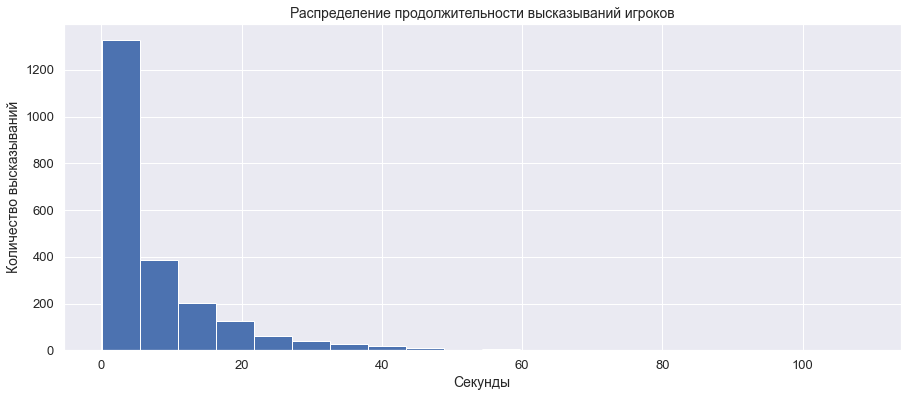

In [94]:
sns.set()
plt.figure(figsize=(15, 6))
plt.hist(speech_len, bins=20)
plt.title('Распределение продолжительности высказываний игроков', fontsize=14)
plt.xlabel('Секунды', fontsize=14)
plt.ylabel('Количество высказываний', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

### Speech duration

In [62]:
def extract_speech_dur(diarization_dct, round_1_dur_dct, round_2_dur_dct, mapper):
    speech_dur_dct = {}
    
    for title, turn in diarization_dct.items():
        temp_dct = defaultdict(lambda: 0)
        
        for line in turn:
            cond = (
                (line['start'] > round_1_dur_dct[title][1]) &
                (line['start'] < round_2_dur_dct[title][0])
            )
            
            if not cond:
                speaker = line['speaker']
                if speaker in mapper[title]:
                    player = mapper[title][speaker]
                    temp_dct[player] += line['stop'] - line['start']
        
        speech_dur_dct[title] = dict(temp_dct)
        
    return speech_dur_dct

In [63]:
speech_dur = extract_speech_dur(
    diarization_dct, round_1_dur_dct, round_2_dur_dct, diarization_mapping_dct
)

### Speech overlap

In [64]:
def calc_speech_overlap(diarization_dct, round_1_dur_dct, round_2_dur_dct, mapper):
    speech_interval = {}
    
    for title, turn in diarization_dct.items():
        temp_dct = defaultdict(lambda: [])
        
        for line in turn:
            cond = (
                (line['start'] > round_1_dur_dct[title][1]) &
                (line['start'] < round_2_dur_dct[title][0])
            )
            
            if not cond:
                speaker = line['speaker']
                if speaker in mapper[title]:
                    player = mapper[title][speaker]
                    temp_dct[player].append([line['start'], line['stop']])
        
        speech_interval[title] = dict(temp_dct)
        
    intersection = {}
    for title, player_int in speech_interval.items():
        temp_lst = []
        if len(player_int) < 2:
            continue
        else:
            for player_1 in player_int['player_1']:
                for player_2 in player_int['player_2']:
                    temp_left = max(player_1[0], player_2[0])
                    temp_right = min(player_1[1], player_2[1])
                    if temp_left < temp_right:
                        temp_lst.append([temp_left, temp_right])
        
        intersection[title] = temp_lst
        
    return intersection

In [65]:
speech_overlap = calc_speech_overlap(
    diarization_dct, round_1_dur_dct, round_2_dur_dct, diarization_mapping_dct
)

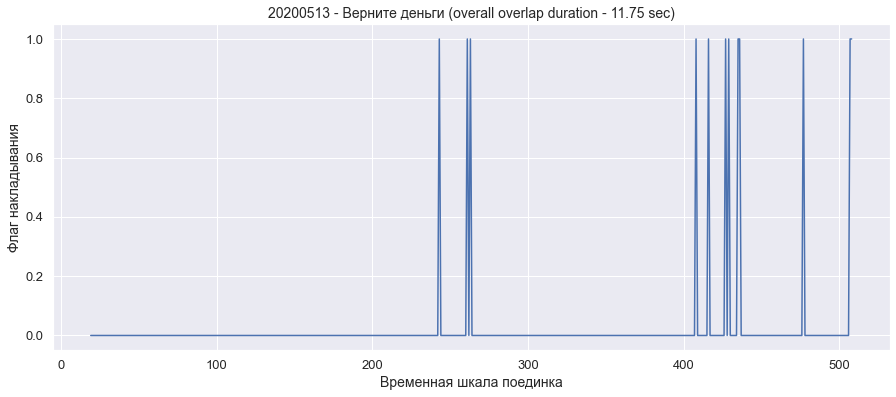

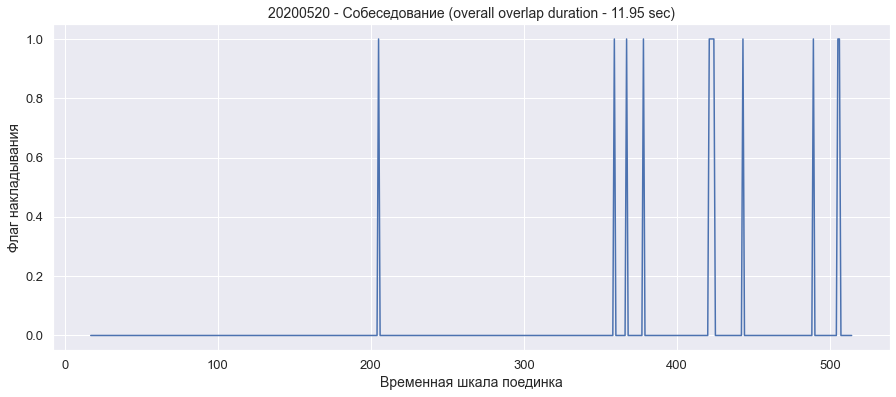

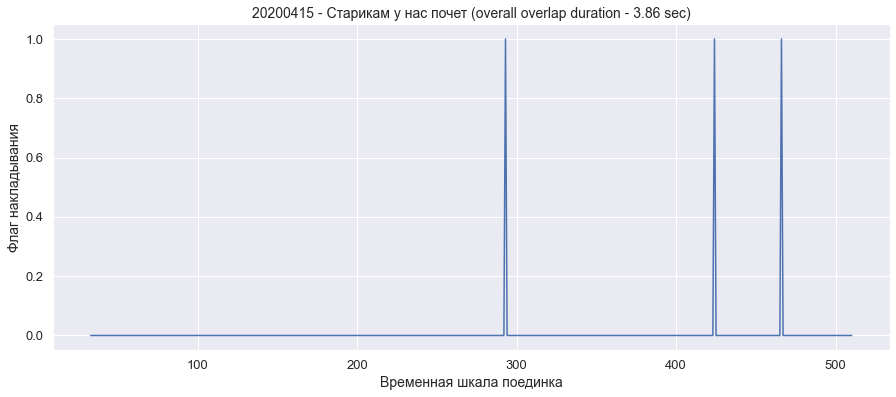

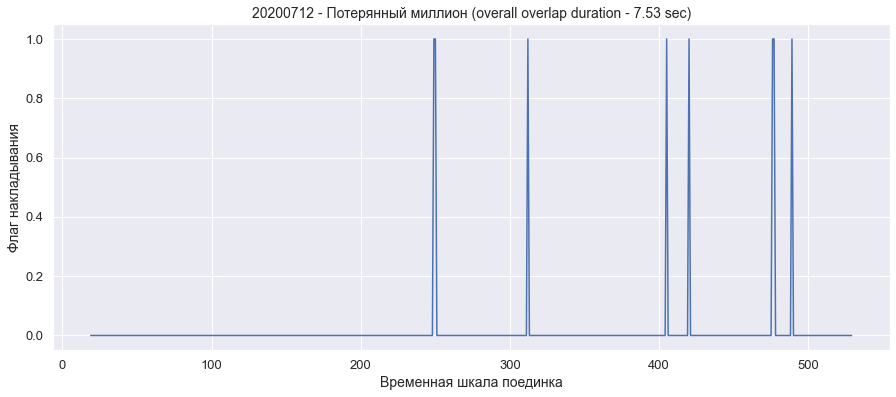

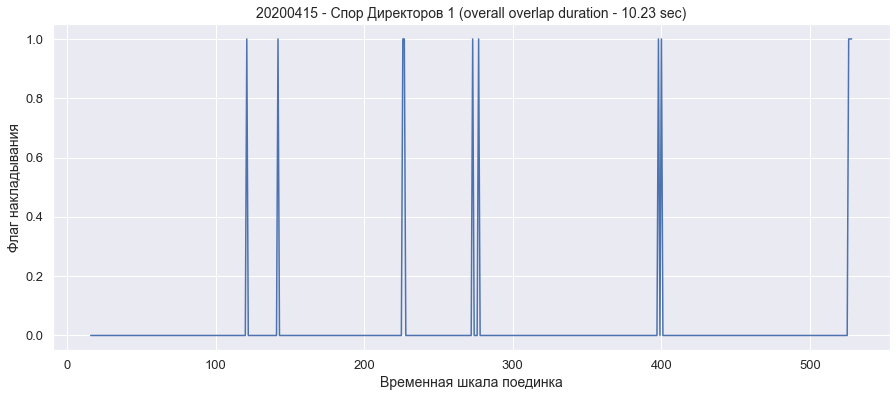

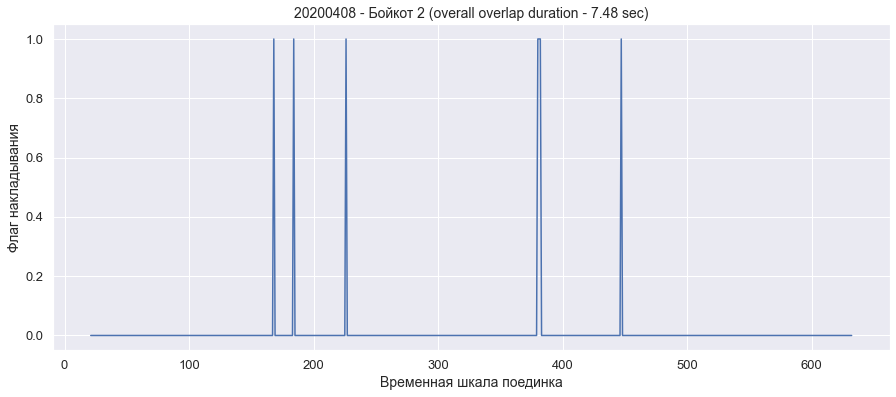

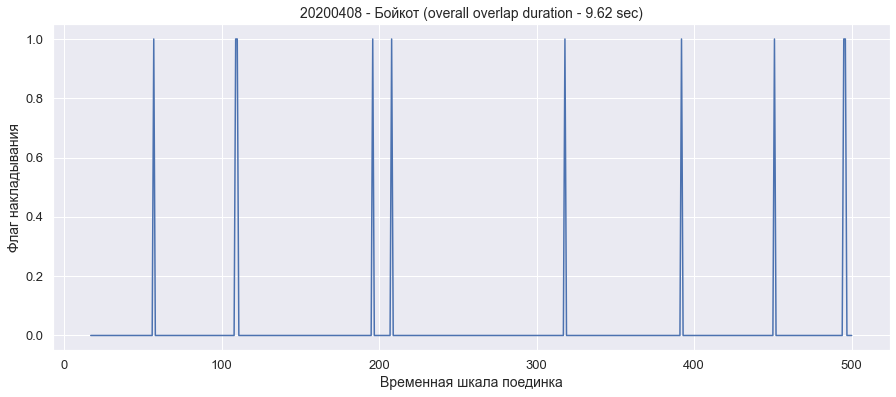

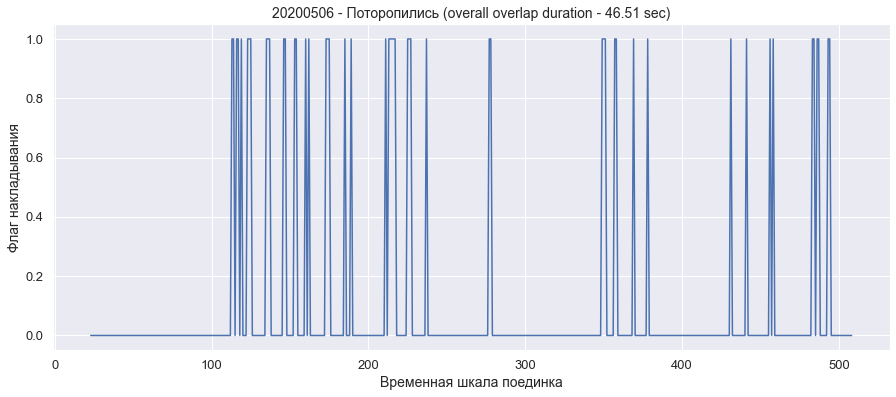

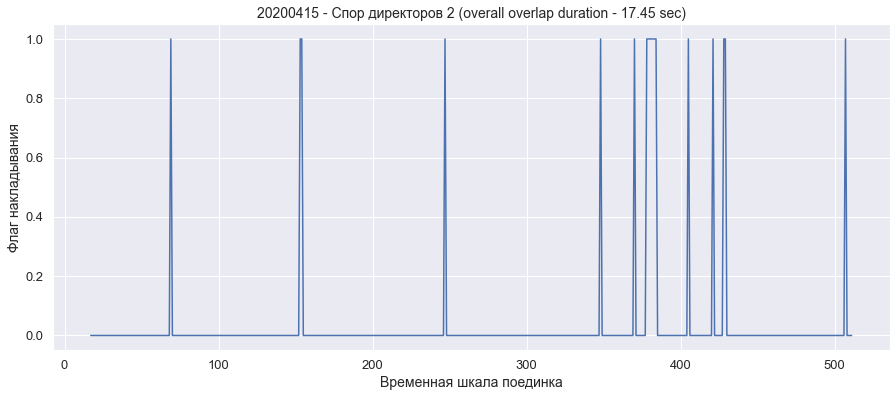

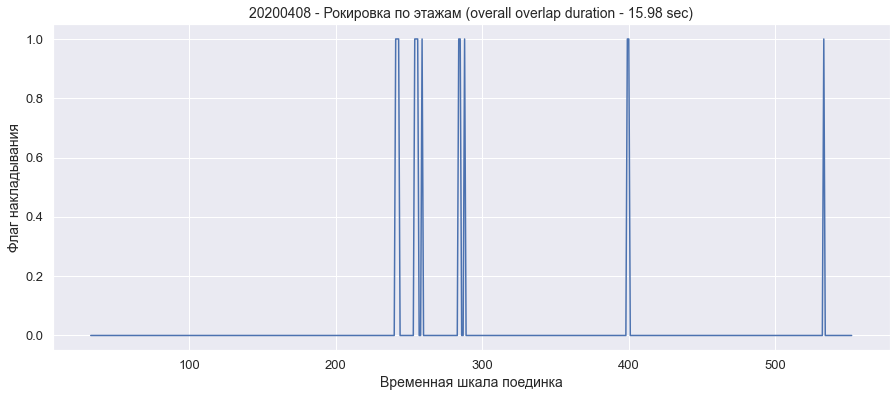

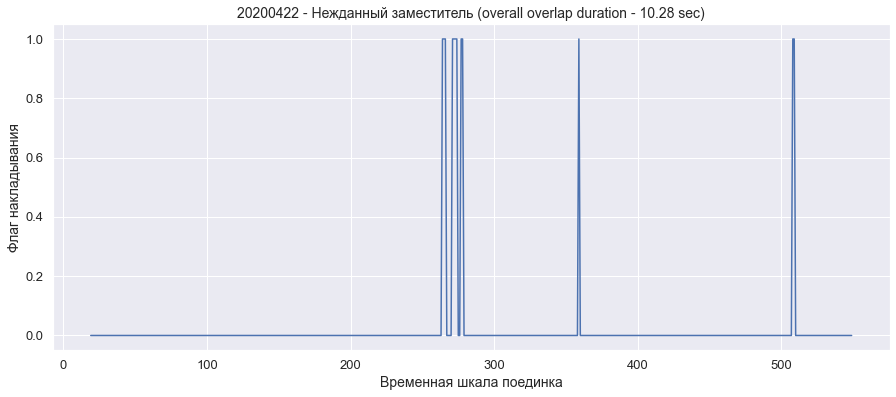

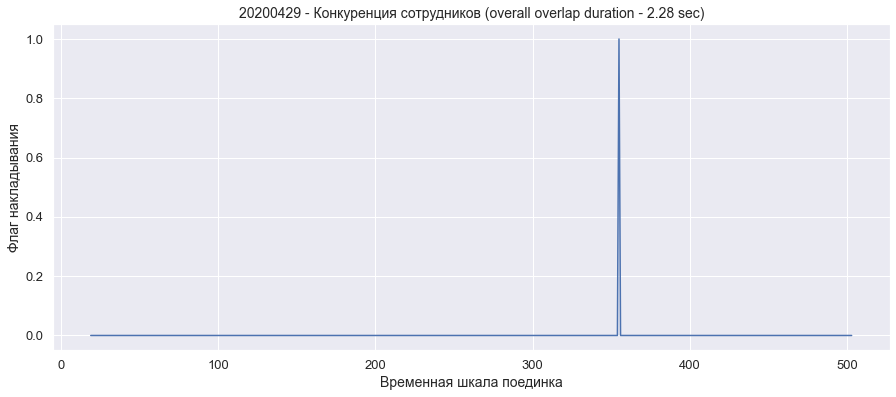

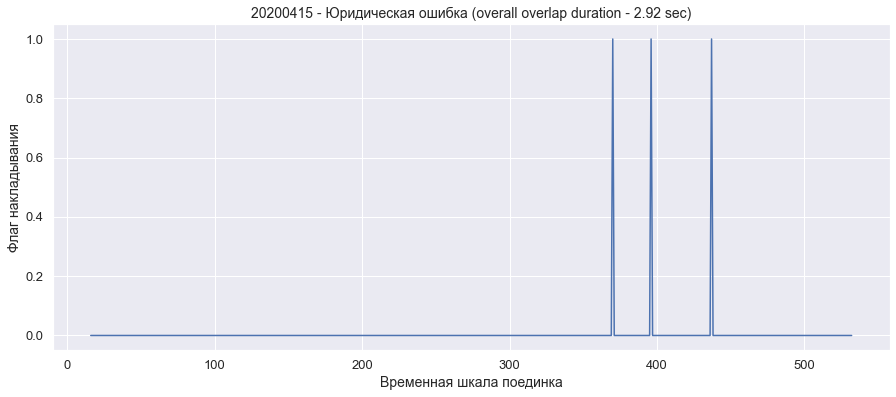

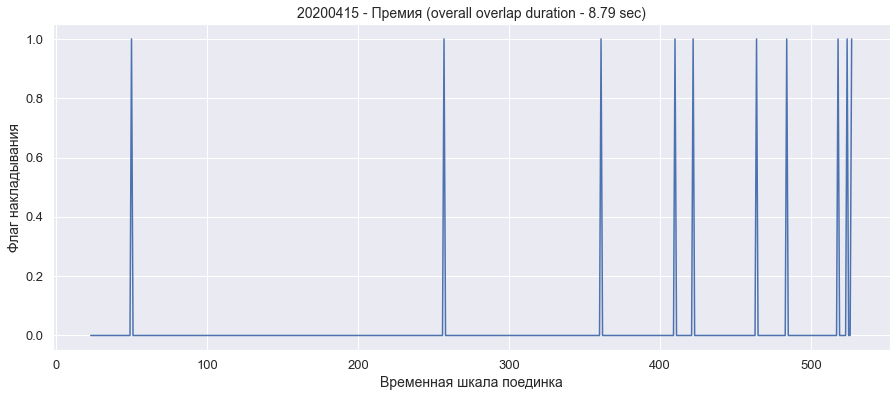

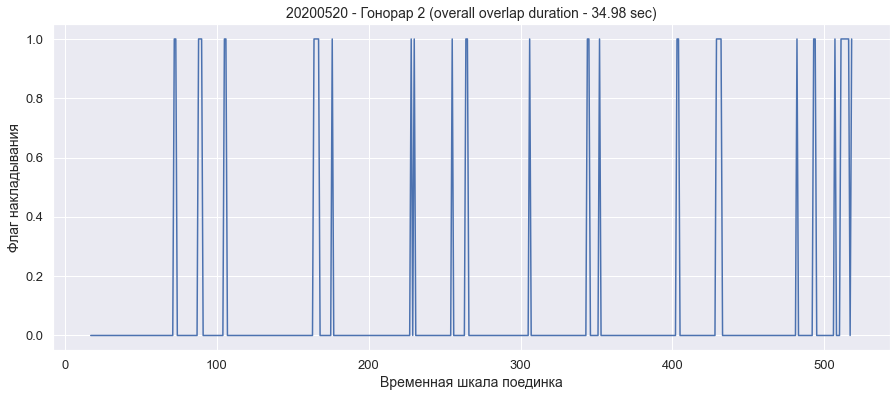

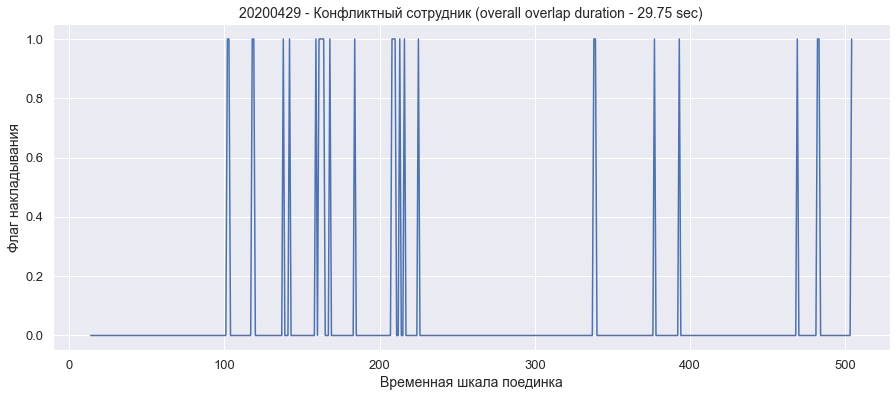

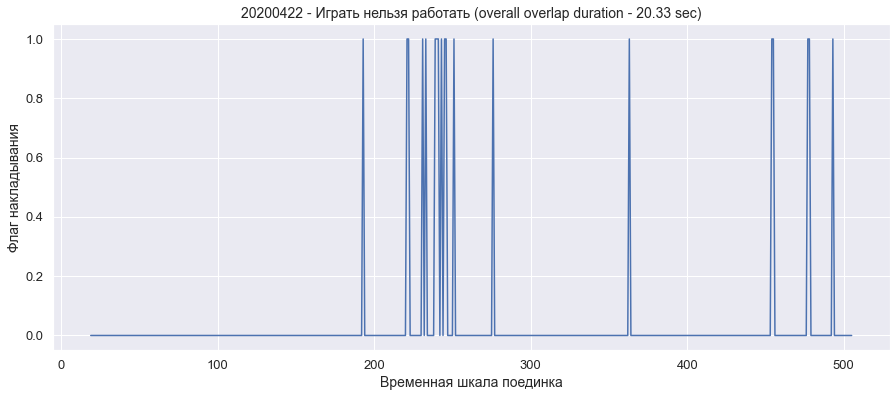

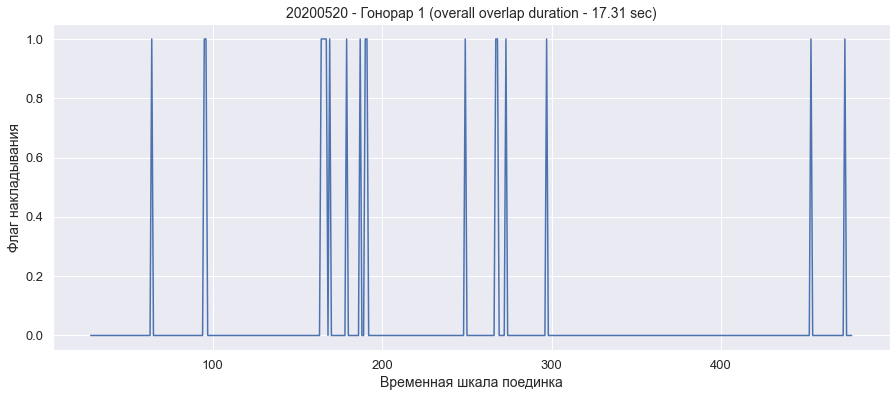

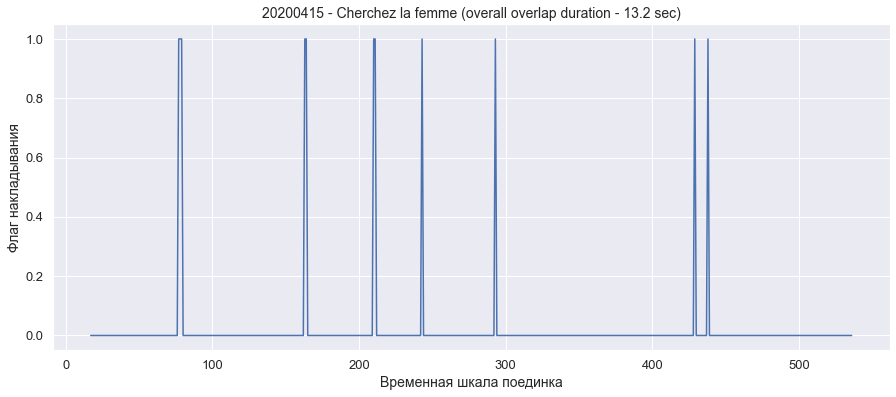

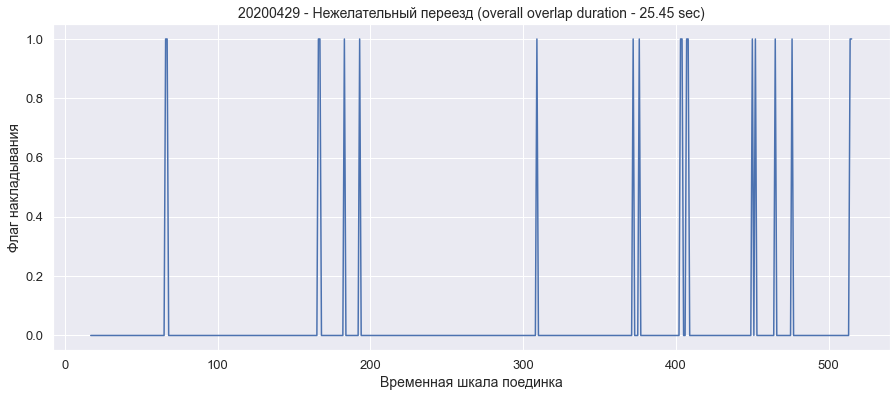

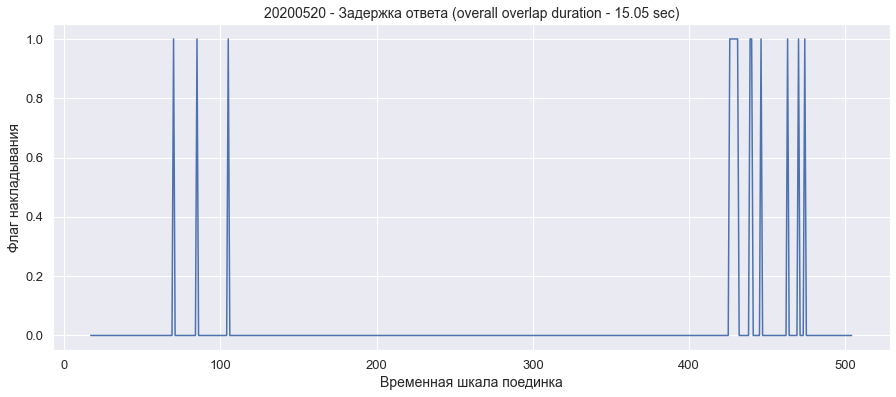

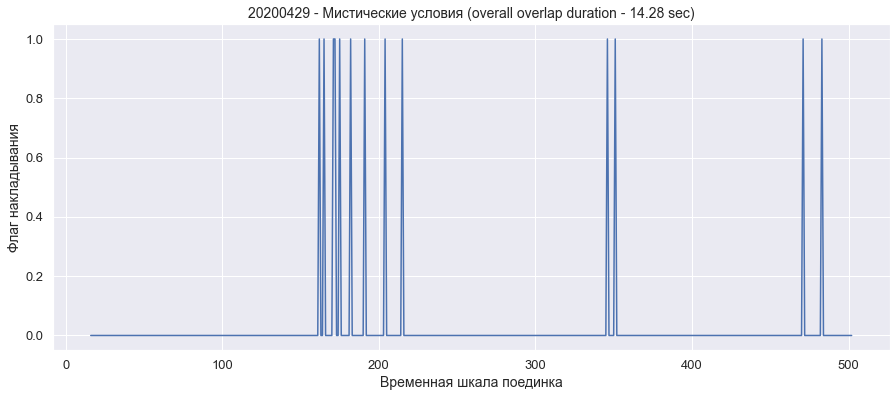

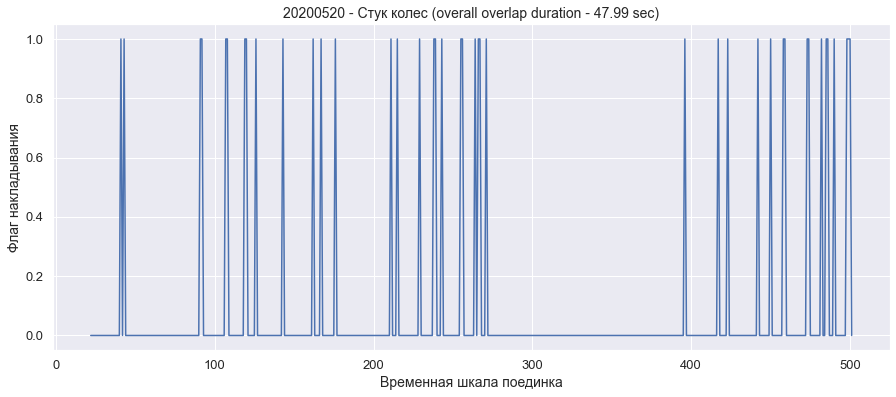

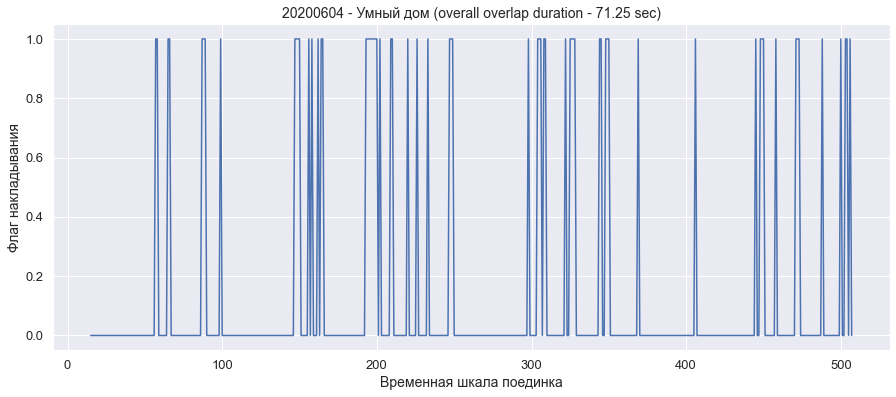

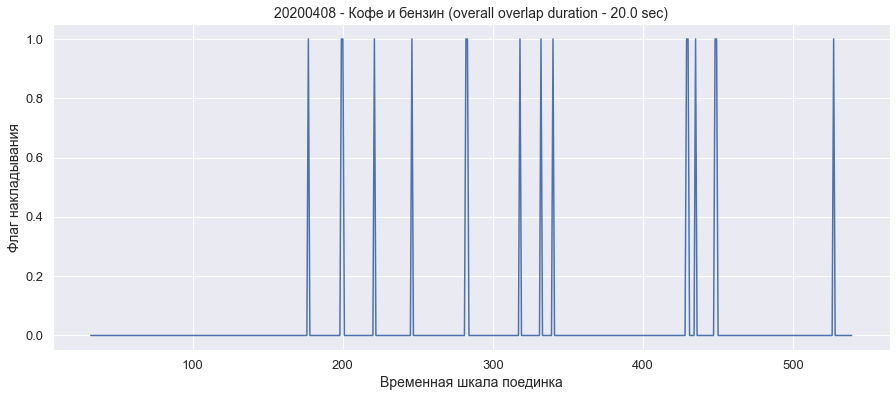

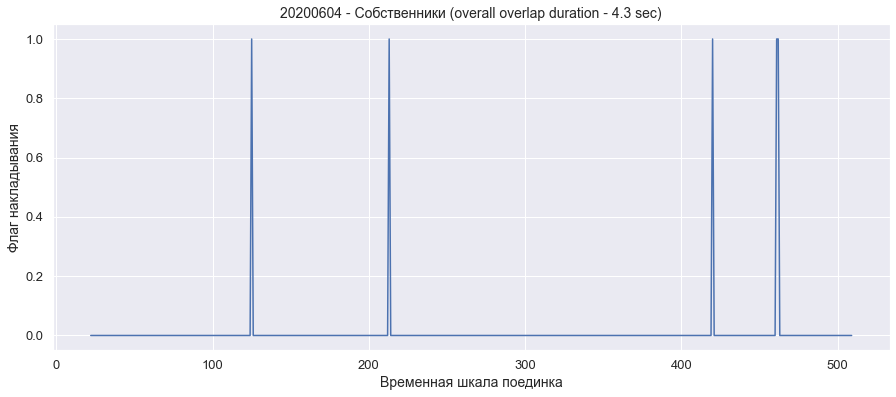

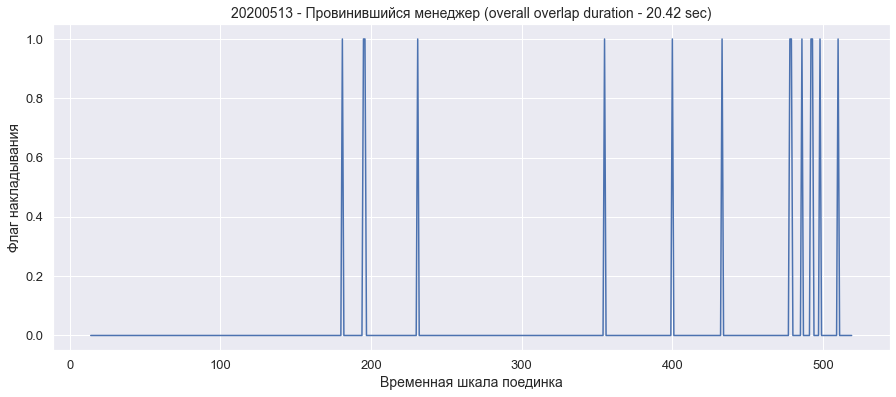

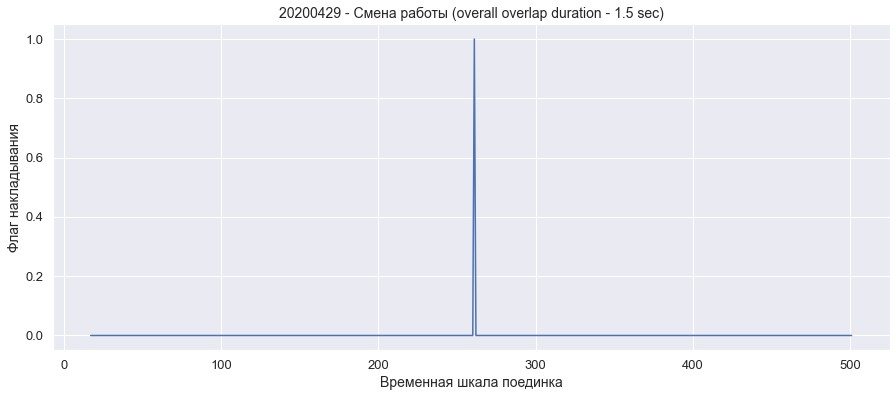

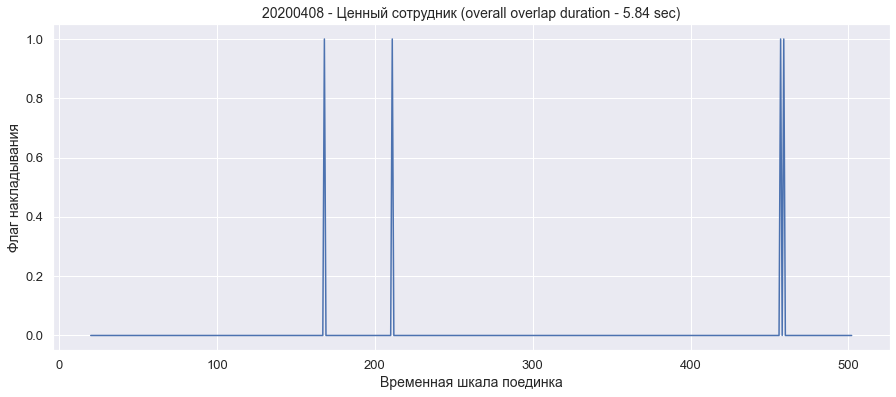

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

overlap_dist = []
all_overlap = []

for title in speech_overlap:
    negotiation_overlap = np.zeros(
        round_2_dur_dct[title][1] -
        round_1_dur_dct[title][0]
    )
    negotiation_len = np.arange(
        round_1_dur_dct[title][0],
        round_2_dur_dct[title][1]
    )
    
    overlap_counter = 0
    for left_bound, right_bound in speech_overlap[title]:
        negotiation_overlap[int(left_bound):int(right_bound)] = 1
        overlap_counter += right_bound - left_bound
        all_overlap.append(right_bound - left_bound)
    
    true_dur = (
        round_1_dur_dct[title][1] - round_1_dur_dct[title][0] +
        round_2_dur_dct[title][1] - round_2_dur_dct[title][0]
    )
    overlap_dist.append(overlap_counter / true_dur)
    
    plt.figure(figsize=(15, 6))
    plt.plot(negotiation_len, negotiation_overlap)
    plt.title(
        f'{title} (overall overlap duration - {np.round(overlap_counter, 2)} sec)',
        fontsize=14
    )
    plt.ylabel('Флаг накладывания', fontsize=14)
    plt.xlabel('Временная шкала поединка', fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.show()

In [67]:
np.median(overlap_dist)

0.026183035714285798

In [100]:
np.mean(all_overlap)

1.1345047433035738

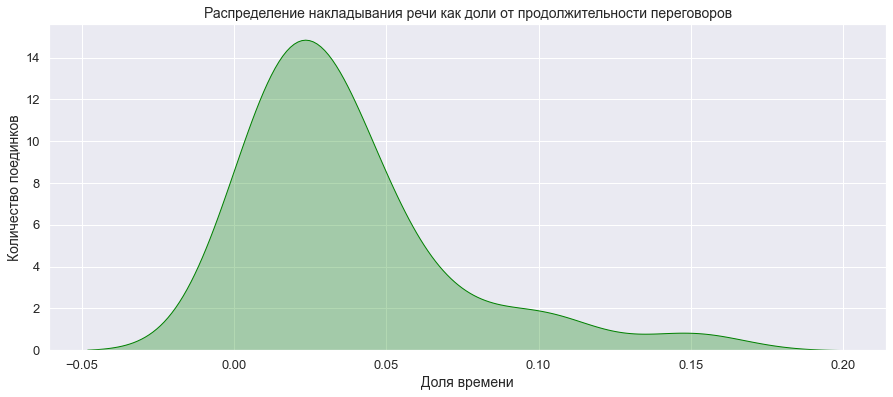

In [69]:
plt.figure(figsize=(15, 6))
sns.kdeplot(overlap_dist, fill=True, alpha=0.3, color='green')
plt.title(
    'Распределение накладывания речи как доли от продолжительности переговоров',
    fontsize=14
)
plt.xlabel('Доля времени', fontsize=14)
plt.ylabel('Количество поединков', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

### EDA для самого текста

In [549]:
from collections import defaultdict

# !!!!!!!! change docs
def combine_speech_and_speakers(captions, diarization, round_1_end, round_2_start, mapper):
    """Combine captions and diarization. 
    
    Parameters
    ----------
    captions : list of dict
        Array with captions for a certain audio/video file.
        Each dict has 'text', 'start' and 'duration' as keys.
    diarization : list of dict
        Array with diarization information for a certain audio.
        Each dict has 'start', 'stop' and 'speaker' as keys.
    
    Returns
    -------
    speech_df : pandas DataFrame
        Table with speech and its time.
        
    Notes
    -----
    As it's impossible to perfectly match YouTube captions time intervals
    and diarization time intervals the following algorithm simply looks if
    diarization interval includes YouTube interval.
    If there are unused captions (i.e. they were skipped) they are added
    to the latest speaker and ignored if IndexError raises.
    """
    speech_dct = {'text': [], 'speaker': [], 'n_round': []}
    
    for idx, caption in enumerate(captions):
        round_cond = (
            (caption['start'] > round_1_end) &
            (caption['start'] < round_2_start)
        )
        
        if not round_cond:
            
            overlap_time = defaultdict(lambda: 0)
            for turn in diarization:
                left_overlap = max(turn['start'], caption['start'])
                right_overlap = min(turn['stop'], caption['start'] + caption['duration'])
                if left_overlap < right_overlap:
                    overlap_time[turn['speaker']] += right_overlap - left_overlap
            
            # longest speaker
            if overlap_time:
                longest_speaker = sorted(overlap_time.items(), key=lambda x: x[1])[-1][0]
                if longest_speaker in mapper:
                    speech_dct['speaker'].append(mapper[longest_speaker])
                    speech_dct['text'].append(caption['text'])
                    
                    n_round = 1 if caption['start'] < round_1_end else 2
                    speech_dct['n_round'].append(n_round)
            
    return speech_dct

In [550]:
def join_speakers(speech_dct):
    joined_speech_dct = {'speaker': [], 'text': [], 'n_round': []}
    last_speaker = -1
    for speaker, text, n_round in zip(speech_dct['speaker'], speech_dct['text'], speech_dct['n_round']):
        if speaker == last_speaker:
            joined_speech_dct['text'][-1] += ' ' + text
            joined_speech_dct['n_round'][-1] = n_round
        else:
            joined_speech_dct['speaker'].append(speaker)
            joined_speech_dct['text'].append(text)
            joined_speech_dct['n_round'].append(n_round)
            last_speaker = speaker
            
    return joined_speech_dct

In [560]:
from tqdm import tqdm
combined_speech_and_speakers = {}
joined_speech_and_speakers = {}

In [561]:
for key in tqdm(list(diarization_dct.keys())):
    cond = (
        (len(set([turn['speaker'] for turn in diarization_dct[key]])) > 1) &
        (key != '20200415 - Cherchez la femme')
    )
    if cond:
        speech_speakers = combine_speech_and_speakers(
            yt_captions[key], diarization_dct[key],
            round_1_dur_dct[key][1], round_2_dur_dct[key][0], diarization_mapping_dct[key]
        )
        no_dot_music_text = list(
            map(
                lambda x: x.replace('.', '').replace('[музыка]', ''), speech_speakers['text']
            )
        )
        combined_speech_and_speakers[key] = {
            'text': no_dot_music_text, 'speaker': speech_speakers['speaker'], 
            'n_round': speech_speakers['n_round']
        }
        joined_speech = join_speakers(combined_speech_and_speakers[key])
        spelled_text = spell_text(joined_speech['text'])
        restored_text = restore_punctuation(spelled_text)
        
        joined_speech_and_speakers[key] = {
            'text': restored_text, 'speaker': joined_speech['speaker'],
            'n_round': joined_speech['n_round']
        }

100%|███████████████████████████████████████████| 35/35 [02:10<00:00,  3.73s/it]


In [562]:
# with open('data/combined_speech_and_speakers.pkl', mode='wb') as f:
#     pickle.dump(combined_speech_and_speakers, f)
# with open('data/joined_speech_and_speakers.pkl', mode='wb') as f:
#     pickle.dump(joined_speech_and_speakers, f)

In [563]:
with open('data/combined_speech_and_speakers.pkl', mode='rb') as f:
    combined_speech = pickle.load(f)
with open('data/joined_speech_and_speakers.pkl', mode='rb') as f:
    joined_speech = pickle.load(f)

In [199]:
speech_speed = []
for title, text_speaker in combined_speech.items():
    player_one, player_two = 0, 0
    for idx in range(len(text_speaker['text'])):
        if text_speaker['speaker'][idx] == 'player_1':
            player_one += len(text_speaker['text'][idx].split())
        else:
            player_two += len(text_speaker['text'][idx].split())
    
    speech_speed.append(player_one / speech_dur[title]['player_1'])
    speech_speed.append(player_two / speech_dur[title]['player_2'])

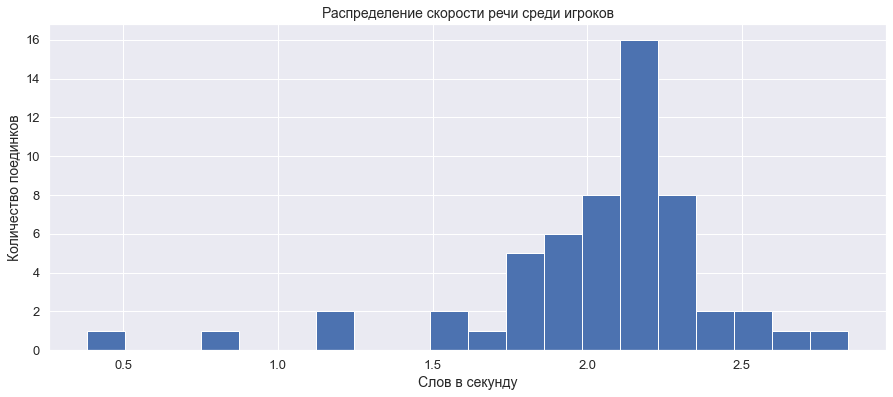

In [201]:
sns.set()
plt.figure(figsize=(15, 6))
plt.hist(speech_speed, bins=20)
plt.title('Распределение скорости речи среди игроков', fontsize=14)
plt.ylabel('Количество поединков', fontsize=14)
plt.xlabel('Слов в секунду', fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

### Сентимент

In [202]:
# !pip install transformers sentencepiece --quiet
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model.cuda()
    
def get_sentiment(text, return_type='label'):
    """ Calculate sentiment of a text. `return_type` can be 'label', 'score' or 'proba' """
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()[0]
    if return_type == 'label':
        return model.config.id2label[proba.argmax()]
    elif return_type == 'score':
        return proba.dot([-1, 0, 1])
    return proba

text = 'Какая гадость эта ваша заливная рыба!'
# classify the text
print(get_sentiment(text, 'label'))  # negative
# score the text on the scale from -1 (very negative) to +1 (very positive)
print(get_sentiment(text, 'score'))  # -0.5894946306943893
# calculate probabilities of all labels
print(get_sentiment(text, 'proba'))  # [0.7870447  0.4947824  0.19755007]


negative
-0.5894947648048401
[0.78704476 0.4947824  0.19755   ]


In [235]:
combined_sentiment = {}
for title, text_speaker in tqdm(joined_speech.items()):
    score = []
    for text in text_speaker['text']:
        score.append(get_sentiment(text, 'score'))
    
    combined_sentiment[title] = score

100%|███████████████████████████████████████████| 28/28 [00:05<00:00,  4.78it/s]


In [236]:
sum([np.median(x) < 0 for x in list(combined_sentiment.values())])

23

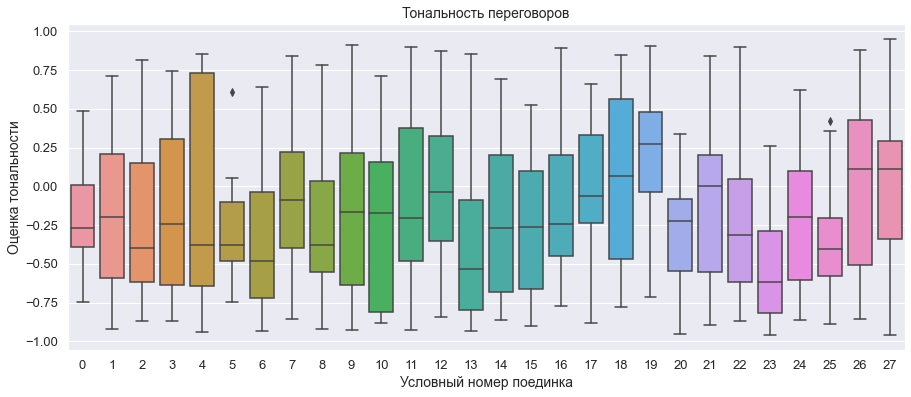

In [237]:
sns.set()
plt.figure(figsize=(15, 6))
sns.boxplot(data=list(combined_sentiment.values()))
plt.title('Тональность переговоров', fontsize=14)
plt.ylabel('Оценка тональности', fontsize=14)
plt.xlabel('Условный номер поединка', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

### Длина высказываний

In [242]:
n_saying_dist = []
for title, dct in joined_speech.items():
    n_saying_dist.extend([len(text.split()) for text in dct['text']])

In [252]:
len(n_saying_dist) / 28

19.0

In [256]:
np.quantile(n_saying_dist, [0.9])

array([100.])

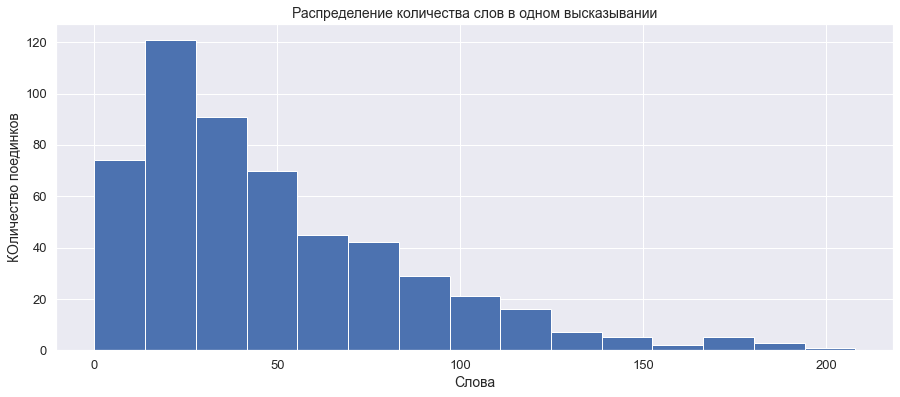

In [248]:
sns.set()
plt.figure(figsize=(15, 6))
plt.hist(n_saying_dist, bins=15)
plt.title('Распределение количества слов в одном высказывании', fontsize=14)
plt.ylabel('КОличество поединков', fontsize=14)
plt.xlabel('Слова', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

### Гипотеза - скорость речи

In [821]:
speech_rate_dct = {
    'judge_1': {'winners': [], 'losers': []},
    'judge_2': {'winners': [], 'losers': []},
    'judge_3': {'winners': [], 'losers': []},
    'judge_4': {'winners': [], 'losers': []},
    'titles': []
}

In [822]:
for title, text_speaker in combined_speech.items():
    speech_rate_dct['titles'].append(title)
    player_one, player_two = 0, 0
    for idx in range(len(text_speaker['text'])):
        if text_speaker['speaker'][idx] == 'player_1':
            player_one += len(text_speaker['text'][idx].split())
        else:
            player_two += len(text_speaker['text'][idx].split())
            
    for i in range(4):
        cond = (
            general_info.loc[
                general_info['title'] == title, 'judge_decision'
            ].values[0][i] == 'player_1'
        )
        if cond:
            speech_rate_dct[f'judge_{i+1}']['winners'].append(
                player_one / speech_dur[title]['player_1']
            )
            speech_rate_dct[f'judge_{i+1}']['losers'].append(
                player_two / speech_dur[title]['player_2']
            )
        else:
            speech_rate_dct[f'judge_{i+1}']['losers'].append(
                player_one / speech_dur[title]['player_1']
            )
            speech_rate_dct[f'judge_{i+1}']['winners'].append(
                player_two / speech_dur[title]['player_2']
            )

### Гипотеза - время говорения

In [855]:
speech_time_dct = {
    'judge_1': {'winners': [], 'losers': []},
    'judge_2': {'winners': [], 'losers': []},
    'judge_3': {'winners': [], 'losers': []},
    'judge_4': {'winners': [], 'losers': []},
    'titles': []
}

In [856]:
for key, value in speech_dur.items():
    if (len(value.keys()) < 2) | (key == '20200415 - Cherchez la femme'):
        continue
        
    speech_time_dct['titles'].append(key)
    for i in range(4):
        cond = (
            general_info.loc[
                general_info['title'] == key, 'judge_decision'
            ].values[0][i] == 'player_1'
        )
        if cond:
            speech_time_dct[f'judge_{i+1}']['winners'].append(value['player_1'])
            speech_time_dct[f'judge_{i+1}']['losers'].append(value['player_2'])
        else:
            speech_time_dct[f'judge_{i+1}']['winners'].append(value['player_2'])
            speech_time_dct[f'judge_{i+1}']['losers'].append(value['player_1'])

### Гипотеза - перебивание

In [825]:
interrupt_dct = {
    'judge_1': {'winners': [], 'losers': []},
    'judge_2': {'winners': [], 'losers': []},
    'judge_3': {'winners': [], 'losers': []},
    'judge_4': {'winners': [], 'losers': []},
    'titles': []
}

In [826]:
for title, turns in diarization_dct.items():
    if (len(speech_dur[title].keys()) < 2) | (title == '20200415 - Cherchez la femme'):
        continue
    
    interrupt_dct['titles'].append(title)
    player_penalty = {'player_1': 0, 'player_2': 0}
    
    prev_start = 0
    prev_stop = 0
    prev_speaker = 0
    for turn in turns:
        cond = (
            (turn['start'] > round_1_dur_dct[title][1]) &
            (turn['start'] < round_2_dur_dct[title][0])
        )
        
        if (not cond) & (turn['speaker'] in diarization_mapping_dct[title]):
            curr_speaker = diarization_mapping_dct[title][turn['speaker']]
            curr_start = turn['start']
            curr_stop = turn['stop']
            left_bound = max(curr_start, prev_start)
            right_bound = min(curr_stop, prev_stop)
            if (
                (prev_stop - prev_start > 5) &
                (right_bound - left_bound > 2) &
                (curr_speaker != prev_speaker)
            ):
                player_penalty[curr_speaker] += prev_stop - curr_start
                
            prev_start = curr_start
            prev_stop = curr_stop
            prev_speaker = curr_speaker
    
    for i in range(4):
        cond = (
            general_info.loc[
                general_info['title'] == title, 'judge_decision'
            ].values[0][i] == 'player_1'
        )
        if cond:
            interrupt_dct[f'judge_{i+1}']['winners'].append(player_penalty['player_1'])
            interrupt_dct[f'judge_{i+1}']['losers'].append(player_penalty['player_2'])
        else:
            interrupt_dct[f'judge_{i+1}']['winners'].append(player_penalty['player_2'])
            interrupt_dct[f'judge_{i+1}']['losers'].append(player_penalty['player_1'])

### Гипотеза - знаки вопросов

In [827]:
question_dct = {
    'judge_1': {'winners': [], 'losers': []},
    'judge_2': {'winners': [], 'losers': []},
    'judge_3': {'winners': [], 'losers': []},
    'judge_4': {'winners': [], 'losers': []},
    'titles': []
}

In [828]:
for title, text_speaker in joined_speech.items():
    question_dct['titles'].append(title)
    
    player_questions = {'player_1': 0, 'player_2': 0}
    
    for text, speaker in zip(text_speaker['text'], text_speaker['speaker']):
        player_questions[speaker] += text.count('?')
    
    for i in range(4):
        cond = (
            general_info.loc[
                general_info['title'] == title, 'judge_decision'
            ].values[0][i] == 'player_1'
        )
        if cond:
            question_dct[f'judge_{i+1}']['winners'].append(player_questions['player_1'])
            question_dct[f'judge_{i+1}']['losers'].append(player_questions['player_2'])
        else:
            question_dct[f'judge_{i+1}']['winners'].append(player_questions['player_2'])
            question_dct[f'judge_{i+1}']['losers'].append(player_questions['player_1']) 

### Гипотеза - речь/ситуация

In [829]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
MODEL_NAME = 'cointegrated/rut5-base-absum'
model_sum = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer_sum = T5Tokenizer.from_pretrained(MODEL_NAME)
# model.cuda();
model_sum.eval();

def summarize(
    text, n_words=None, compression=None,
    max_length=1000, num_beams=3, do_sample=False, repetition_penalty=10.0, 
    **kwargs
):
    """
    Summarize the text
    The following parameters are mutually exclusive:
    - n_words (int) is an approximate number of words to generate.
    - compression (float) is an approximate length ratio of summary and original text.
    """
    if n_words:
        text = '[{}] '.format(n_words) + text
    elif compression:
        text = '[{0:.1g}] '.format(compression) + text
    x = tokenizer_sum(text, return_tensors='pt', padding=True).to(model_sum.device)
    with torch.inference_mode():
        out = model_sum.generate(
            **x, 
            max_length=max_length, num_beams=num_beams, 
            do_sample=do_sample, repetition_penalty=repetition_penalty, 
            **kwargs
        )
    return tokenizer_sum.decode(out[0], skip_special_tokens=True)

In [830]:
from transformers import AutoTokenizer, AutoModel
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")


In [831]:
from scipy.spatial.distance import cosine

In [834]:
speech_desc_dct = {
    'judge_1': {'winners': [], 'losers': []},
    'judge_2': {'winners': [], 'losers': []},
    'judge_3': {'winners': [], 'losers': []},
    'judge_4': {'winners': [], 'losers': []},
    'titles': []
}

In [835]:
for title, text_speaker in tqdm(joined_speech.items()):
    speech_desc_dct['titles'].append(title)
    
    desc = summarize(general_info.loc[general_info['title'] == title, 'desc'].values[0], compression=0.2)
    encoded_desc = tokenizer(desc, padding=True, max_length=None, return_tensors='pt')

    with torch.no_grad():
        desc_output = model(**encoded_desc)
    
    desc_emb = mean_pooling(desc_output, encoded_desc['attention_mask'])
    
    speech_embeddings = {'player_1': [], 'player_2': []}
    
    for text, speaker in zip(text_speaker['text'], text_speaker['speaker']):
        encoded_player = tokenizer(summarize(text, compression=0.4), padding=True, max_length=None, return_tensors='pt')
        with torch.no_grad():
            player_output = model(**encoded_player)
            
        player_emb = mean_pooling(player_output, encoded_player['attention_mask'])
                
        cosine_similarity = 1 - cosine(desc_emb[0], player_emb[0])
        speech_embeddings[speaker].append(cosine_similarity)
        
    for i in range(4):
        cond = (
            general_info.loc[
                general_info['title'] == title, 'judge_decision'
            ].values[0][i] == 'player_1'
        )
        if cond:
            speech_desc_dct[f'judge_{i+1}']['winners'].append(
                np.mean(speech_embeddings['player_1'])
            )
            speech_desc_dct[f'judge_{i+1}']['losers'].append(
                np.mean(speech_embeddings['player_2'])
            )
        else:
            speech_desc_dct[f'judge_{i+1}']['winners'].append(
                np.mean(speech_embeddings['player_2'])
            )
            speech_desc_dct[f'judge_{i+1}']['losers'].append(
                np.mean(speech_embeddings['player_1'])
            )

100%|███████████████████████████████████████████| 28/28 [17:23<00:00, 37.27s/it]


### Гипотеза - речь/роль

In [839]:
speech_role_dct = {
    'judge_1': {'winners': [], 'losers': []},
    'judge_2': {'winners': [], 'losers': []},
    'judge_3': {'winners': [], 'losers': []},
    'judge_4': {'winners': [], 'losers': []},
    'titles': []
}

speech_role_opponent_dct = {
    'judge_1': {'winners': [], 'losers': []},
    'judge_2': {'winners': [], 'losers': []},
    'judge_3': {'winners': [], 'losers': []},
    'judge_4': {'winners': [], 'losers': []},
    'titles': []
}

In [840]:
for title, text_speaker in tqdm(joined_speech.items()):
    speech_role_dct['titles'].append(title)
    speech_role_opponent_dct['titles'].append(title)
    
    roles_dct = general_info.loc[general_info['title'] == title, 'role_interest'].values[0]
    round_1_roles = general_info.loc[general_info['title'] == title, 'round_1_role'].values[0]
    round_2_roles = general_info.loc[general_info['title'] == title, 'round_2_role'].values[0]
    
    round_1_role_1 = round_1_roles[0]
    round_1_role_2 = round_1_roles[1]
    round_2_role_1 = round_2_roles[0]
    round_2_role_2 = round_2_roles[1]
    
    #
    encoded_round_1_role_1 = tokenizer(summarize(roles_dct[round_1_role_1], compression=0.5), padding=True, max_length=None, return_tensors='pt')
    with torch.no_grad():
        round_1_role_1_output = model(**encoded_round_1_role_1)
    
    round_1_role_1_emb = mean_pooling(round_1_role_1_output, encoded_round_1_role_1['attention_mask'])
    
    #
    encoded_round_1_role_2 = tokenizer(summarize(roles_dct[round_1_role_2], compression=0.5), padding=True, max_length=None, return_tensors='pt')
    with torch.no_grad():
        round_1_role_2_output = model(**encoded_round_1_role_2)
    
    round_1_role_2_emb = mean_pooling(round_1_role_2_output, encoded_round_1_role_2['attention_mask'])
    
    #
    encoded_round_2_role_1 = tokenizer(summarize(roles_dct[round_2_role_1], compression=0.5), padding=True, max_length=None, return_tensors='pt')
    with torch.no_grad():
        round_2_role_1_output = model(**encoded_round_2_role_1)
    
    round_2_role_1_emb = mean_pooling(round_2_role_1_output, encoded_round_2_role_1['attention_mask'])
    
    #
    encoded_round_2_role_2 = tokenizer(summarize(roles_dct[round_2_role_2], compression=0.5), padding=True, max_length=None, return_tensors='pt')
    with torch.no_grad():
        round_2_role_2_output = model(**encoded_round_2_role_2)
    
    round_2_role_2_emb = mean_pooling(round_2_role_2_output, encoded_round_2_role_2['attention_mask'])
    
    speech_embeddings = {'player_1': [], 'player_2': []}
    speech_embeddings_opponent = {'player_1': [], 'player_2': []}
    
    for text, speaker, n_round in zip(text_speaker['text'], text_speaker['speaker'], text_speaker['n_round']):
        
        if n_round == 1:
            encoded_player = tokenizer(summarize(text, compression=0.4), padding=True, max_length=None, return_tensors='pt')
            with torch.no_grad():
                player_output = model(**encoded_player)

            player_emb = mean_pooling(player_output, encoded_player['attention_mask'])
            
            role_emb = round_1_role_1_emb if speaker == 'player_1' else round_1_role_2_emb
            role_opponent_emb = round_1_role_2_emb if speaker == 'player_1' else round_1_role_1_emb
            
            cosine_similarity = 1 - cosine(role_emb[0], player_emb[0])
            cosine_similarity_opponent = 1 - cosine(role_opponent_emb[0], player_emb[0])
            
            speech_embeddings[speaker].append(cosine_similarity)
            speech_embeddings_opponent[speaker].append(cosine_similarity_opponent)
            
        else:
            encoded_player = tokenizer(summarize(text, compression=0.4), padding=True, max_length=None, return_tensors='pt')
            with torch.no_grad():
                player_output = model(**encoded_player)

            player_emb = mean_pooling(player_output, encoded_player['attention_mask'])
            
            role_emb = round_2_role_1_emb if speaker == 'player_1' else round_2_role_2_emb
            role_opponent_emb = round_2_role_2_emb if speaker == 'player_1' else round_2_role_1_emb

            cosine_similarity = 1 - cosine(role_emb[0], player_emb[0])
            cosine_similarity_opponent = 1 - cosine(role_opponent_emb[0], player_emb[0])
            
            speech_embeddings[speaker].append(cosine_similarity)
            speech_embeddings_opponent[speaker].append(cosine_similarity_opponent)
        
    for i in range(4):
        cond = (
            general_info.loc[
                general_info['title'] == title, 'judge_decision'
            ].values[0][i] == 'player_1'
        )
        if cond:
            speech_role_dct[f'judge_{i+1}']['winners'].append(
                np.mean(speech_embeddings['player_1'])
            )
            speech_role_dct[f'judge_{i+1}']['losers'].append(
                np.mean(speech_embeddings['player_2'])
            )
            
            speech_role_opponent_dct[f'judge_{i+1}']['winners'].append(
                np.mean(speech_embeddings_opponent['player_1'])
            )
            speech_role_opponent_dct[f'judge_{i+1}']['losers'].append(
                np.mean(speech_embeddings_opponent['player_2'])
            ) 
        else:
            speech_role_dct[f'judge_{i+1}']['winners'].append(
                np.mean(speech_embeddings['player_2'])
            )
            speech_role_dct[f'judge_{i+1}']['losers'].append(
                np.mean(speech_embeddings['player_1'])
            )
            
            speech_role_opponent_dct[f'judge_{i+1}']['winners'].append(
                np.mean(speech_embeddings_opponent['player_2'])
            )
            speech_role_opponent_dct[f'judge_{i+1}']['losers'].append(
                np.mean(speech_embeddings_opponent['player_1'])
            )

100%|███████████████████████████████████████████| 28/28 [20:07<00:00, 43.12s/it]


### Гипотеза - релевантность

In [843]:
relevance_dct = {
    'judge_1': {'winners': [], 'losers': []},
    'judge_2': {'winners': [], 'losers': []},
    'judge_3': {'winners': [], 'losers': []},
    'judge_4': {'winners': [], 'losers': []},
    'titles': []
}

In [844]:
for title, text_speaker in tqdm(joined_speech.items()):
    relevance_dct['titles'].append(title)
    
    speech_embeddings = {'player_1': [], 'player_2': []}
    
    prev_emb = 0
    for text, speaker in zip(text_speaker['text'], text_speaker['speaker']):
        encoded_player = tokenizer(summarize(text, compression=0.4), padding=True, max_length=None, return_tensors='pt')
        with torch.no_grad():
            player_output = model(**encoded_player)
            
        player_emb = mean_pooling(player_output, encoded_player['attention_mask'])
        
        if not isinstance(prev_emb, int):
            cosine_similarity = 1 - cosine(player_emb[0], prev_emb[0])
            speech_embeddings[speaker].append(cosine_similarity)
        prev_emb = player_emb
        
    for i in range(4):
        cond = (
            general_info.loc[
                general_info['title'] == title, 'judge_decision'
            ].values[0][i] == 'player_1'
        )
        if cond:
            relevance_dct[f'judge_{i+1}']['winners'].append(
                np.mean(speech_embeddings['player_1'])
            )
            relevance_dct[f'judge_{i+1}']['losers'].append(
                np.mean(speech_embeddings['player_2'])
            )
        else:
            relevance_dct[f'judge_{i+1}']['winners'].append(
                np.mean(speech_embeddings['player_2'])
            )
            relevance_dct[f'judge_{i+1}']['losers'].append(
                np.mean(speech_embeddings['player_1'])
            )

100%|███████████████████████████████████████████| 28/28 [16:20<00:00, 35.00s/it]


### Гипотеза - связность

In [846]:
coherence_dct = {
    'judge_1': {'winners': [], 'losers': []},
    'judge_2': {'winners': [], 'losers': []},
    'judge_3': {'winners': [], 'losers': []},
    'judge_4': {'winners': [], 'losers': []},
    'titles': []
}

In [847]:
for title, text_speaker in tqdm(combined_speech.items()):
    coherence_dct['titles'].append(title)
    
    speech_embeddings = {'player_1': [], 'player_2': []}
    
    prev_emb = 0
    prev_speaker = 0
    
    for text, speaker in zip(text_speaker['text'], text_speaker['speaker']):
        encoded_player = tokenizer(text, padding=True, max_length=None, return_tensors='pt')
        with torch.no_grad():
            player_output = model(**encoded_player)
            
        player_emb = mean_pooling(player_output, encoded_player['attention_mask'])
        
        if speaker == prev_speaker:
            cosine_similarity = 1 - cosine(player_emb[0], prev_emb[0])
            speech_embeddings[speaker].append(cosine_similarity)
        
        prev_speaker = speaker
        prev_emb = player_emb
        
    for i in range(4):
        cond = (
            general_info.loc[
                general_info['title'] == title, 'judge_decision'
            ].values[0][i] == 'player_1'
        )
        if cond:
            coherence_dct[f'judge_{i+1}']['winners'].append(
                np.mean(speech_embeddings['player_1'])
            )
            coherence_dct[f'judge_{i+1}']['losers'].append(
                np.mean(speech_embeddings['player_2'])
            )
        else:
            coherence_dct[f'judge_{i+1}']['winners'].append(
                np.mean(speech_embeddings['player_2'])
            )
            coherence_dct[f'judge_{i+1}']['losers'].append(
                np.mean(speech_embeddings['player_1'])
            )

100%|███████████████████████████████████████████| 28/28 [11:02<00:00, 23.67s/it]


### Гипотеза - тональность речи

In [849]:
# !pip install transformers sentencepiece --quiet
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
tokenizer_tone = AutoTokenizer.from_pretrained(model_checkpoint)
model_tone = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
if torch.cuda.is_available():
    model_tone.cuda()
    
def get_sentiment(text, return_type='label'):
    """ Calculate sentiment of a text. `return_type` can be 'label', 'score' or 'proba' """
    with torch.no_grad():
        inputs = tokenizer_tone(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model_tone(**inputs).logits).cpu().numpy()[0]
    if return_type == 'label':
        return model_tone.config.id2label[proba.argmax()]
    elif return_type == 'score':
        return proba.dot([-1, 0, 1])
    return proba

In [850]:
speech_tone_dct = {
    'judge_1': {'winners': [], 'losers': []},
    'judge_2': {'winners': [], 'losers': []},
    'judge_3': {'winners': [], 'losers': []},
    'judge_4': {'winners': [], 'losers': []},
    'titles': []
}

In [851]:
for title, text_speaker in tqdm(joined_speech.items()):
    speech_tone_dct['titles'].append(title)
    player_score = {'player_1': [], 'player_2': []}
    
    for text, speaker in zip(text_speaker['text'], text_speaker['speaker']):
        player_score[speaker].append(get_sentiment(text, 'score'))
    
    for i in range(4):
        cond = (
            general_info.loc[
                general_info['title'] == title, 'judge_decision'
            ].values[0][i] == 'player_1'
        )
        if cond:
            speech_tone_dct[f'judge_{i+1}']['winners'].append(
                np.mean(player_score['player_1'])
            )
            speech_tone_dct[f'judge_{i+1}']['losers'].append(
                np.mean(player_score['player_2'])
            )
        else:
            speech_tone_dct[f'judge_{i+1}']['winners'].append(
                np.mean(player_score['player_2'])
            )
            speech_tone_dct[f'judge_{i+1}']['losers'].append(
                np.mean(player_score['player_1'])
            )

100%|███████████████████████████████████████████| 28/28 [00:04<00:00,  5.89it/s]


In [857]:
speech_vocal_final_dct = {
    'speech_rate': speech_rate_dct,
    'speech_dur': speech_time_dct,
    'speech_interrupt': interrupt_dct,
    'speech_question': question_dct,
    'speech_situation': speech_desc_dct,
    'speech_role': speech_role_dct,
    'speech_role_opponent': speech_role_opponent_dct,
    'speech_relevance': relevance_dct,
    'speech_coherence': coherence_dct,
    'speech_tone': speech_tone_dct,
}

In [858]:
with open('data/speech_vocal_testing_dct.pkl', mode='wb') as f:
    pickle.dump(speech_vocal_final_dct, f)

In [908]:
np.exp(1.7443) / (np.exp(1.7443) + 1)

0.8512324221589272

In [920]:
const = 1.7443
b = -16.1175

eq = const + b*np.mean(speech_vocal_final_dct['speech_role_opponent']['judge_4']['winners'])
odds = np.exp(eq)
prob = odds / (1 + odds)
prob

0.008243690077542356

In [936]:
len(speech_vocal_final_dct['speech_role']['judge_4']['winners'])

28

In [935]:
np.mean(speech_vocal_final_dct['speech_role']['judge_4']['losers'])

0.41632433975011457